In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customer_df = pd.read_csv('../data/clean/customer_dataset_transformed.csv')

display(customer_df.head())

/var/folders/t_/k5bhrc1x419crrfg_t8zp5nm0000gp/T/ipykernel_47065/101853793.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  customer_df = pd.read_csv('../data/clean/customer_dataset_transformed.csv')


,fullVisitorId,visit_number,hits_per_visit,bounced,time_on_site,totals_transactionRevenue,log_transactionRevenue,day_of_week,month,channelGrouping,device_category,country,is_weekend,is_holiday_season
0,59488412965267,1,1,1.0,0,0,0.0,2,2,2,1,213,0.0,0.0
1,85840370633780,1,2,0.0,13,0,0.0,4,9,4,0,213,0.0,0.0
2,118334805178127,1,1,1.0,0,0,0.0,4,10,3,1,213,0.0,0.0
3,166374699289385,1,5,0.0,41,0,0.0,2,8,4,0,213,0.0,0.0
4,197671390269035,1,1,1.0,0,0,0.0,1,5,7,1,213,0.0,0.0


In [3]:
customer_df.shape

(813362, 14)

# Model Implementation

## Stage 1: Train a Classification model to predict if a user will make a purchase (`log_transactionRevenue` > 0)
Create a binary `purchase_flag` column (`purchase_flag = (log_transactionRevenue > 0).astype(int)`)
    - 1 if `log_transactionRevenue` > 0 (user made a purchase).
    - 0 if `log_transactionRevenue` == 0 (user didn’t make a purchase).


In [6]:
# Create the purchase_flag column
customer_df['purchase_flag'] = (customer_df['log_transactionRevenue'] > 0).astype(int)

# Check the distribution of the target variable
print(customer_df['purchase_flag'].value_counts())

purchase_flag
0    803590
1      9772
Name: count, dtype: int64


<br>

#### Prepare Data for Classification

In [8]:
from sklearn.model_selection import train_test_split

# Features and target
X = customer_df.drop(columns=['log_transactionRevenue', 'purchase_flag', 'totals_transactionRevenue', 'fullVisitorId'])
y = customer_df['purchase_flag']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (650689, 11)
Testing set size: (162673, 11)


<br>

### **Random Forest**
Random Forest is selected as initial model due to its ability to handle categorical and numerical features without scaling.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1, required to evaluate the performance metric ROC-AUC

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    160719
           1       0.53      0.27      0.36      1954

    accuracy                           0.99    162673
   macro avg       0.76      0.63      0.68    162673
weighted avg       0.99      0.99      0.99    162673

ROC-AUC Score: 0.9768


The ROC-AUC measures the model's ability to distinguish between classes.

#### Interpretation
1. **ROC-AUC Score: 0.9768**: the model is very good at distinguishing between buyers (class 1) and non-buyers (class 0). However, a high AUC does not guarantee good performance for imbalanced datasets.

##### Class 1 (Buyers)
2. **Precision = 0.53**: Only 53% of users predicted as buyers were actual buyers; The model makes a lot of false positives for class 1.
3. **Recall = 0.27**: The model only identifies 27% of actual buyers; Many actual buyers are missed (false negatives are high).
4. **F1-Score = 0.36**: This combines precision and recall and reflecs poor performance for buyers (class 1).

##### Overall metrics
5. Accuracy = 0.99: Accuracy is misleadingly high because class 0 (non-buyers) dominates the dataset. The model predicts class 0 very well due to its imbalance, inflating the accuracy.
6. Macro Avg (Precision, Recall, F1-Score): These metrics take the average of the metrics for both classes without weighting by class size.
7. Weighted Avg (Precision, Recall, F1-Score): These metrics are weighted by the number of samples in each class. Since class 0 dominates, the weighted average heavily reflects its performance.


#### Summary:
- Model Bias Towards Class 0:
    - The model performs almost perfectly for class 0 (non-buyers), but struggles with class 1 (buyers). This is common in imbalanced datasets.

- High False Negatives for Class 1:
    - The recall for class 1 is low (0.27), meaning the model misses most buyers. This is problematic because in marketing applications, identifying buyers is the goal.

<br>

#### Handle the class imbalance

In [15]:
# Distribution of the target variable
print(customer_df['purchase_flag'].value_counts())

purchase_flag
0    803590
1      9772
Name: count, dtype: int64


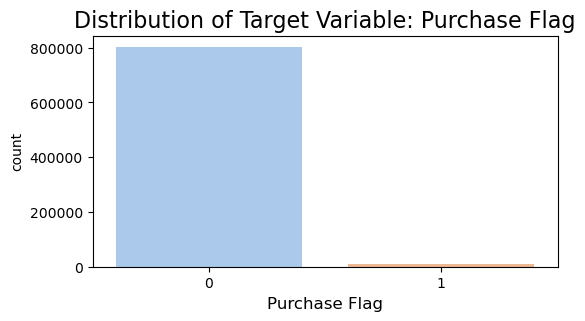

In [16]:
plt.figure(figsize=(6, 3))
sns.countplot(x='purchase_flag', data=customer_df, palette="pastel", hue='purchase_flag', legend=False)

plt.title('Distribution of Target Variable: Purchase Flag', fontsize=16)
plt.xlabel('Purchase Flag', fontsize=12)

plt.show()

There is a severe class imbalance in teh dataset:
- Non-buyers (`purchase_flag` = 0): 803,590 instances (~98.8% of the data).
- Buyers (`purchase_flag` = 1): 9,772 instances (~1.2% of the data).

#### Oversampling the minotiry class with SMOTE

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print(f"Original class distribution:\n{y_train.value_counts()}")
print(f"Resampled class distribution:\n{pd.Series(y_train_smote).value_counts()}")

Original class distribution:
purchase_flag
0    642871
1      7818
Name: count, dtype: int64
Resampled class distribution:
purchase_flag
0    642871
1    642871
Name: count, dtype: int64


In [20]:
# Train a Random Forest classifier with oversampled dataset
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [21]:
# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    160719
           1       0.34      0.59      0.44      1954

    accuracy                           0.98    162673
   macro avg       0.67      0.79      0.71    162673
weighted avg       0.99      0.98      0.98    162673

ROC-AUC Score: 0.9792


#### Interpretation
##### Class 1 (Buyers):
- Precision = 0.34:
    - The model struggles with precision, meaning that many users predicted as buyers are not actual buyers (high false positives).
- Recall = 0.59:
    - A **significant improvement** compared to the pre-SMOTE result (recall ~0.27 earlier). The model now **correctly identifies 59% of actual buyers**.
- F1-Score = 0.44:
    - Improved compared to pre-SMOTE (F1 ~0.36 earlier), indicating better balance between precision and recall.

<br>

#### Experiment with Class Weights
Combine SMOTE with class weighting to help the model pay even more attention to buyers (class 1) during training.

In [24]:
rf_model = RandomForestClassifier(class_weight={0: 1, 1: 5}, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight={0: 1, 1: 5}, random_state=42)

Threshold Tuning:
Adjust the classification threshold to balance precision and recall further for buyers:

In [26]:
threshold = 0.4
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    160719
           1       0.31      0.69      0.43      1954

    accuracy                           0.98    162673
   macro avg       0.65      0.83      0.71    162673
weighted avg       0.99      0.98      0.98    162673



#### Improvement Observed:
- Class 1 Recall = 0.69: A significant improvement compared to the initial results where recall was much lower (~0.27 without SMOTE and weighting). The model is now *identifying 69% of actual buyers*.
- Threshold Tuning: By lowering the threshold to 0.4, there is more balance between recall and precision for class 1, improving the ability to catch buyers.

<br>

#### Hyperparameter Tuning
Hyperparameter tuning can optimize the models's performance even further. __Random Forest__ has several parameters that can significantly affect its ability to generalize and handle imbalanced data:

- `n_estimators`: The number of trees in the forest. More trees typically improve performance but increase training time. New range: [100, 200, 300, 500].
- `max_depth`: The maximum depth of each tree. Controls how much the trees grow; smaller values prevent overfitting. New range: [10, 20, 30, None].
- `min_samples_split`: The minimum number of samples required to split an internal node. Higher values reduce overfitting. New range: [2, 5, 10].
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. Larger values prevent the model from learning overly specific patterns. New range: [1, 2, 5].
- `class_weight`: I've already added {0: 1, 1: 5}. Tuning this further may yield improvements.

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [{0: 1, 1: 5}]
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=2,  # 2-fold cross-validation
    n_jobs=-1  # Use all available cores
)

# Fit on the resampled training data
grid_search.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 5}],
                         'max_depth': [20, None], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [89]:
# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'class_weight': {0: 1, 1: 5}, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


**Best Parameters**:
- `class_weight`: `{0: 1, 1: 5}`. The model gives 5x more weight to the minority class (buyers) compared to the majority class (non-buyers).
- `max_depth`: `None`. Trees grow until all leaves are pure or contain less than the min_samples_split.
- `min_samples_leaf`: `1`. Allows leaves to have as few as one sample.
- `min_samples_split`: `2`. Splits nodes with at least two samples, ensuring highly flexible trees. 
- `n_estimators`: `200`.  Uses 200 trees in the Random Forest, balancing computational efficiency and performance.

In [93]:
# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(
    class_weight={0: 1, 1: 5},
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# Fit the model
best_rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight={0: 1, 1: 5}, n_estimators=200,
                       random_state=42)

In [95]:
# Predict on the test set
y_pred = best_rf_model.predict(X_test)
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    160719
           1       0.34      0.58      0.43      1954

    accuracy                           0.98    162673
   macro avg       0.67      0.78      0.71    162673
weighted avg       0.99      0.98      0.98    162673

ROC-AUC Score: 0.9793


#### Observations:
- Class 1 Recall = 0.58: A slight drop compared to the SMOTE + class weights + threshold tuning (recall = 0.69 in that setup).
- Class 1 Precision = 0.34: Identical to the prior result, meaning the false positive rate remains consistent.

In [31]:
# # Train the final model using the best parameters
# best_rf_model = grid_search.best_estimator_
# best_rf_model.fit(X_train_smote, y_train_smote)

# # Predict on the test set
# y_pred = best_rf_model.predict(X_test)
# y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]

# # Evaluate the model
# from sklearn.metrics import classification_report, roc_auc_score
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")


In [32]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }
# grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search.fit(X_train_smote, y_train_smote)
# print(grid_search.best_params_)


In [33]:
# from sklearn.ensemble import RandomForestClassifier

# # Train a Random Forest with class weights
# rf_model = RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)
# rf_model.fit(X_train, y_train)

# # Evaluate the model
# y_pred = rf_model.predict(X_test)
# y_pred_prob = rf_model.predict_proba(X_test)[:, 1]



In [34]:
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

# # Print evaluation metrics
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

Undersampling the majority class

In [36]:
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.model_selection import train_test_split

# # Split the data into features (X) and target (y)
# X = customer_df.drop(columns=['log_transactionRevenue', 'totals_transactionRevenue', 'purchase_flag', 'fullVisitorId'])
# y = customer_df['purchase_flag']

# # Split into training and test sets before applying undersampling
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Apply Random Undersampling to the training set
# undersampler = RandomUnderSampler(random_state=42)
# X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# # Check the new class distribution
# print(f"Original class distribution:\n{y_train.value_counts()}")
# print(f"Resampled class distribution:\n{pd.Series(y_train_under).value_counts()}")


train the model

In [38]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, roc_auc_score

# # Train a Random Forest classifier
# rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
# rf_model.fit(X_train_under, y_train_under)

# # Predict on the test set
# y_pred = rf_model.predict(X_test)
# y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# # Evaluate the model
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")


In [39]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.combine import SMOTEENN  # For combining oversampling + undersampling
# from sklearn.model_selection import train_test_split
# import pandas as pd

# # Split the data into features (X) and target (y)
# X = customer_df.drop(columns=['log_transactionRevenue', 'totals_transactionRevenue', 'purchase_flag', 'fullVisitorId'])
# y = customer_df['purchase_flag']

# # Split into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Apply SMOTE + Random Undersampling
# smote = SMOTE(random_state=42)  # SMOTE to oversample
# undersampler = RandomUnderSampler(random_state=42)  # Undersample the majority class

# # First apply SMOTE, then undersampling
# X_smote, y_smote = smote.fit_resample(X_train, y_train)
# X_resampled, y_resampled = undersampler.fit_resample(X_smote, y_smote)

# # Check the new class distribution
# print(f"Original class distribution:\n{y_train.value_counts()}")
# print(f"After SMOTE + Undersampling class distribution:\n{pd.Series(y_resampled).value_counts()}")


In [40]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, roc_auc_score

# # Train a Random Forest classifier
# rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
# rf_model.fit(X_resampled, y_resampled)

# # Predict on the test set
# y_pred = rf_model.predict(X_test)
# y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# # Evaluate the model
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")
